In [43]:
import numpy as np
import pandas as pd  
import seaborn as sns
from scipy.stats import kstest, skew, kurtosis, laplace
import matplotlib.pyplot as plt          

In [29]:
df = pd.read_excel('./data/Petroleo-IPC.xlsx')
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  0 non-null      float64       
 1   Unnamed: 1  0 non-null      float64       
 2   Date        1162 non-null   datetime64[ns]
 3   IPC         1162 non-null   float64       
 4   Oil         1162 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 45.5 KB
None
       Unnamed: 0  Unnamed: 1                           Date           IPC  \
count         0.0         0.0                           1162   1162.000000   
mean          NaN         NaN  2017-07-01 04:17:45.748709120  45765.966821   
min           NaN         NaN            2015-01-02 00:00:00  38574.179690   
25%           NaN         NaN            2016-04-08 18:00:00  43504.626952   
50%           NaN         NaN            2017-06-29 12:00:00  45363.390625   
75%           NaN        

In [30]:
# Formatear el DataFrame
df = df[['Date', 'IPC', 'Oil']]
df.set_index('Date', inplace=True)
print(df.head())

                    IPC    Oil
Date                          
2015-01-02  42115.46875  44.81
2015-01-05  41099.37109  41.52
2015-01-06  41329.41016  39.94
2015-01-07  41813.92969  40.07
2015-01-08  42402.30859  40.47


In [32]:
#  Calcular los rendimientos logarítmicos
returns = np.log(df / df.shift(1)).dropna()
print(returns.head())

                 IPC       Oil
Date                          
2015-01-05 -0.024422 -0.076256
2015-01-06  0.005582 -0.038797
2015-01-07  0.011655  0.003250
2015-01-08  0.013973  0.009933
2015-01-09 -0.000469 -0.019210


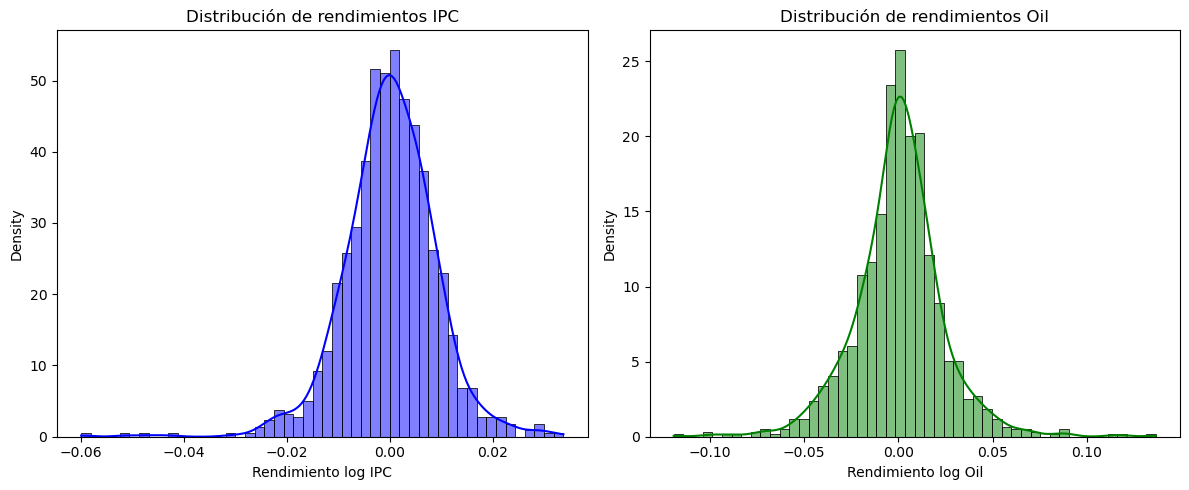

In [35]:
# Gráfico de distribución para IPC y Oil
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(returns["IPC"], bins=50, kde=True, stat="density", ax=axes[0], color="blue")
axes[0].set_title("Distribución de rendimientos IPC")
axes[0].set_xlabel("Rendimiento log IPC")

sns.histplot(returns["Oil"], bins=50, kde=True, stat="density", ax=axes[1], color="green")
axes[1].set_title("Distribución de rendimientos Oil")
axes[1].set_xlabel("Rendimiento log Oil")

plt.tight_layout()
plt.show()


In [37]:
# Ajuste por MLE
mu_ipc, b_ipc = laplace.fit(returns["IPC"])
mu_oil, b_oil = laplace.fit(returns["Oil"])

print("Parámetros Laplace IPC -> mu:", mu_ipc, " b:", b_ipc)
print("Parámetros Laplace Oil -> mu:", mu_oil, " b:", b_oil)


Parámetros Laplace IPC -> mu: 0.0002213564905051723  b: 0.0066151834062241465
Parámetros Laplace Oil -> mu: 0.0006481581732800467  b: 0.016715345569246157


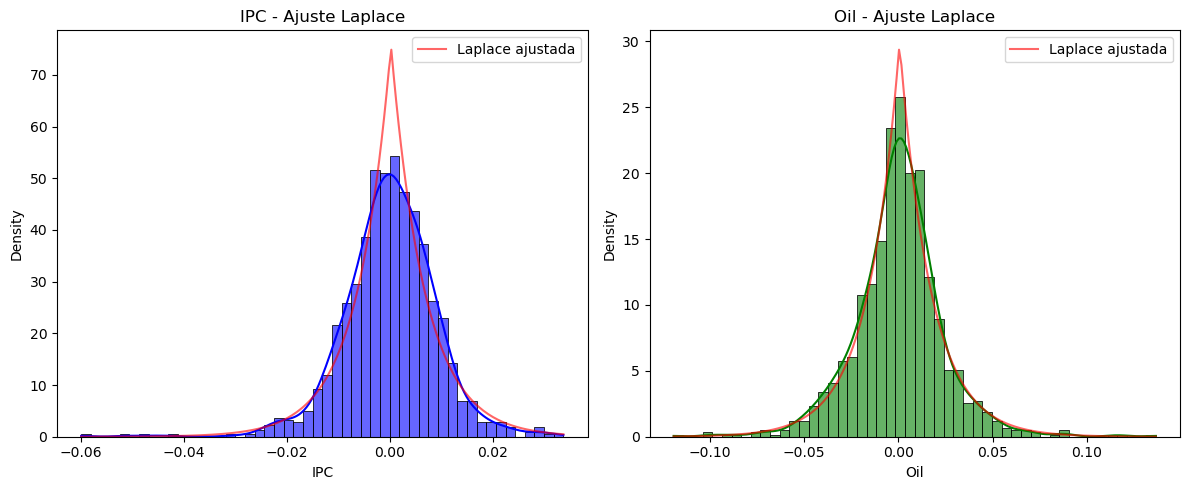

In [50]:
x_ipc = np.linspace(returns["IPC"].min(), returns["IPC"].max(), 200)
x_oil = np.linspace(returns["Oil"].min(), returns["Oil"].max(), 200)

plt.figure(figsize=(12,5))

# IPC
plt.subplot(1,2,1)
sns.histplot(returns["IPC"], bins=50, kde=True, stat="density", color="blue", alpha=0.6)
plt.plot(x_ipc, laplace.pdf(x_ipc, mu_ipc, b_ipc), "r-", alpha=0.6, lw=1.5, label="Laplace ajustada")
plt.title("IPC - Ajuste Laplace")
plt.legend()

# Oil
plt.subplot(1,2,2)
sns.histplot(returns["Oil"], bins=50, kde=True, stat="density", color="green", alpha=0.6)
plt.plot(x_oil, laplace.pdf(x_oil, mu_oil, b_oil), "r-", alpha=0.6, lw=1.5, label="Laplace ajustada")
plt.title("Oil - Ajuste Laplace")
plt.legend()

plt.tight_layout()
plt.show()


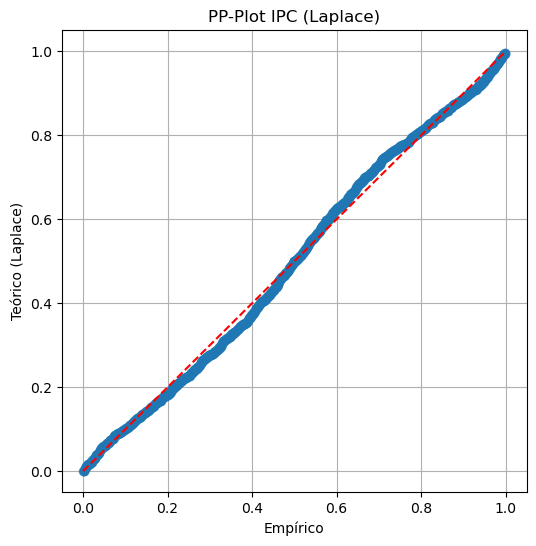

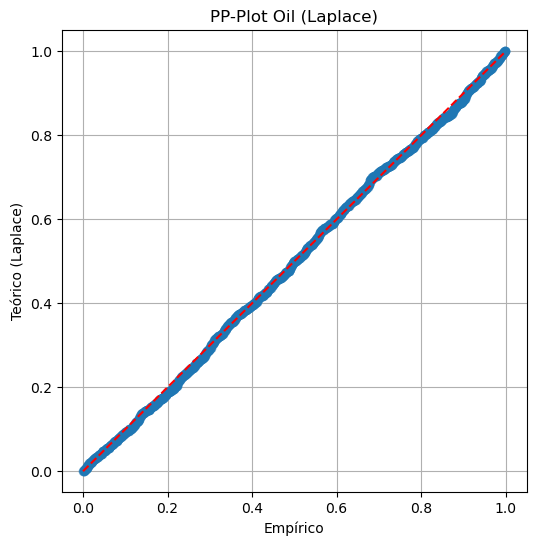

In [39]:
def pp_plot(data, mu, b, title="PP-Plot"):
    # Probabilidades empíricas
    data_sorted = np.sort(data)
    n = len(data_sorted)
    probs_emp = np.arange(1, n+1) / (n+1)

    # Probabilidades teóricas bajo Laplace
    probs_theo = laplace.cdf(data_sorted, loc=mu, scale=b)

    # Gráfico
    plt.figure(figsize=(6,6))
    plt.plot(probs_emp, probs_theo, "o", alpha=0.6)
    plt.plot([0,1], [0,1], "r--")  # línea ideal
    plt.xlabel("Empírico")
    plt.ylabel("Teórico (Laplace)")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Ejemplo IPC
pp_plot(returns["IPC"], mu_ipc, b_ipc, "PP-Plot IPC (Laplace)")

# Ejemplo Oil
pp_plot(returns["Oil"], mu_oil, b_oil, "PP-Plot Oil (Laplace)")


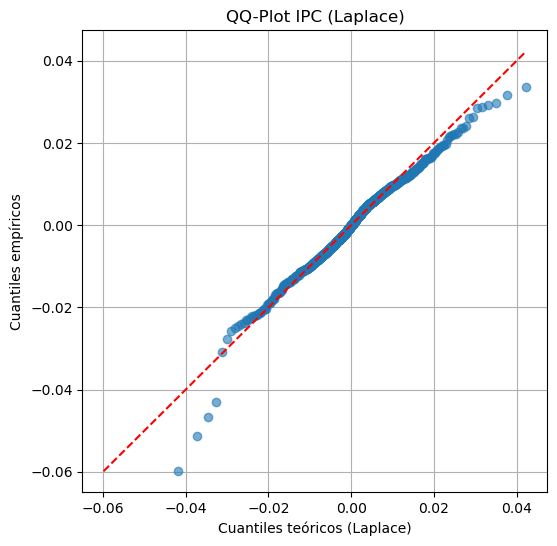

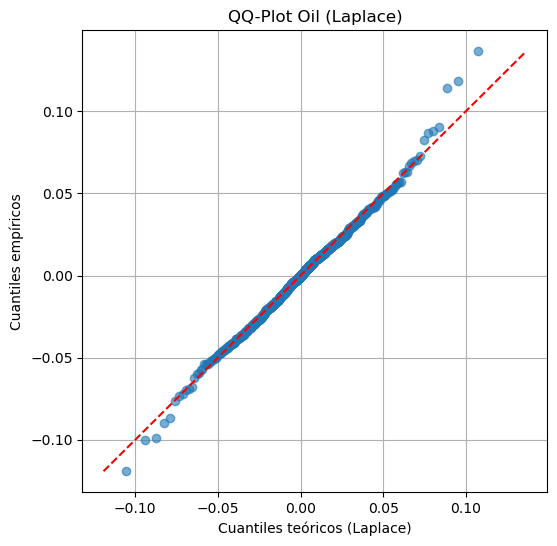

In [40]:
def qq_plot(data, mu, b, title="QQ-Plot"):
    # Ordenamos datos
    data_sorted = np.sort(data)
    n = len(data_sorted)
    
    # Cuantiles teóricos bajo Laplace
    probs = np.arange(1, n+1) / (n+1)
    theo_quants = laplace.ppf(probs, loc=mu, scale=b)
    
    # Gráfico
    plt.figure(figsize=(6,6))
    plt.plot(theo_quants, data_sorted, "o", alpha=0.6)
    min_val = min(data_sorted.min(), theo_quants.min())
    max_val = max(data_sorted.max(), theo_quants.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--")  # línea ideal
    plt.xlabel("Cuantiles teóricos (Laplace)")
    plt.ylabel("Cuantiles empíricos")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Ejemplo IPC
qq_plot(returns["IPC"], mu_ipc, b_ipc, "QQ-Plot IPC (Laplace)")

# Ejemplo Oil
qq_plot(returns["Oil"], mu_oil, b_oil, "QQ-Plot Oil (Laplace)")


In [42]:
# KS test para IPC
ks_ipc = kstest(returns["IPC"], "laplace", args=(mu_ipc, b_ipc))
print("KS Test IPC -> estadístico:", ks_ipc.statistic, "  p-value:", ks_ipc.pvalue)

# KS test para Oil
ks_oil = kstest(returns["Oil"], "laplace", args=(mu_oil, b_oil))
print("KS Test Oil -> estadístico:", ks_oil.statistic, "  p-value:", ks_oil.pvalue)


KS Test IPC -> estadístico: 0.0355223560652157   p-value: 0.10425347494614323
KS Test Oil -> estadístico: 0.02123781814641168   p-value: 0.6634652981817544


In [44]:
# IPC
skew_ipc = skew(returns["IPC"])
kurt_ipc = kurtosis(returns["IPC"], fisher=False)  # fisher=False → curtosis "total"
print("IPC -> Skewness:", skew_ipc, " Curtosis:", kurt_ipc)

# Oil
skew_oil = skew(returns["Oil"])
kurt_oil = kurtosis(returns["Oil"], fisher=False)
print("Oil -> Skewness:", skew_oil, " Curtosis:", kurt_oil)


IPC -> Skewness: -0.5456924726126908  Curtosis: 6.94168433698258
Oil -> Skewness: 0.12569711051807983  Curtosis: 6.653056682224093
